# Project Information

Goal of this project is to apply techniques and models covered over the semester to create accurate sales projections for a retail store.

End goal is to use multiple models to create an ensemble method, intent is to use 1-2 fine tuned models in conjunction with random forest

# Notebook Setup

Install python

In [ ]:
import sys
assert sys.version_info >= (3,7)

Import pandas, numpy and matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(72)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Import needed libraries for scaling and models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

std_scaler= StandardScaler()


# Data Import

Going to be using a Wal-Mart data set from kaggle, easiest import is still manually downloading, uploading to google drive and then importing from there

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mount the google drive location, and then import via pandas

In [ ]:
sales_data= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Walmart.xls')
data = sales_data

# Visualization and Exploration

In [ ]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


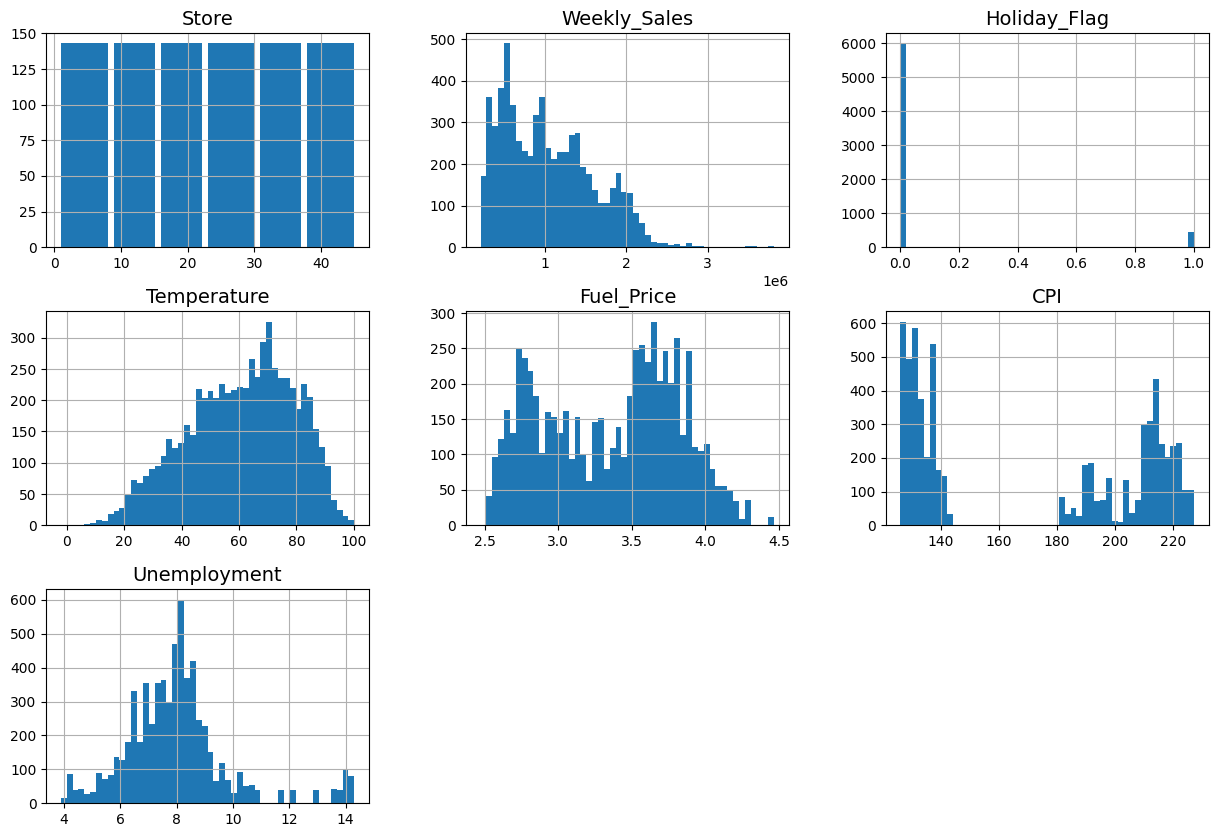

In [ ]:
data.hist(bins=50, figsize=(15, 10))
plt.show()

# Feature Engineering

Goals:



*   convert date to usable format
    * accomplished
*   smooth out tail heavy features
*   create new feature to determine which holiday the flag relates to:  
    * might be too ambitious
*   create new feature for spring/summer/fall/winter
    * accomplished, feature column "Quarter"





First up, need to convert Date feature to something I can work with.

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

Now I can split the Date feature into more meaningful sub features.

In [ ]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Quarter'] = data['Date'].dt.quarter

Multiple features have wide variation, need to standardize before moving forward

In [ ]:
data[['Weekly_Sales','CPI', 'Temperature']]=std_scaler.fit_transform(data[['Weekly_Sales','CPI', 'Temperature']])
data = data.drop('Date', axis = 1)

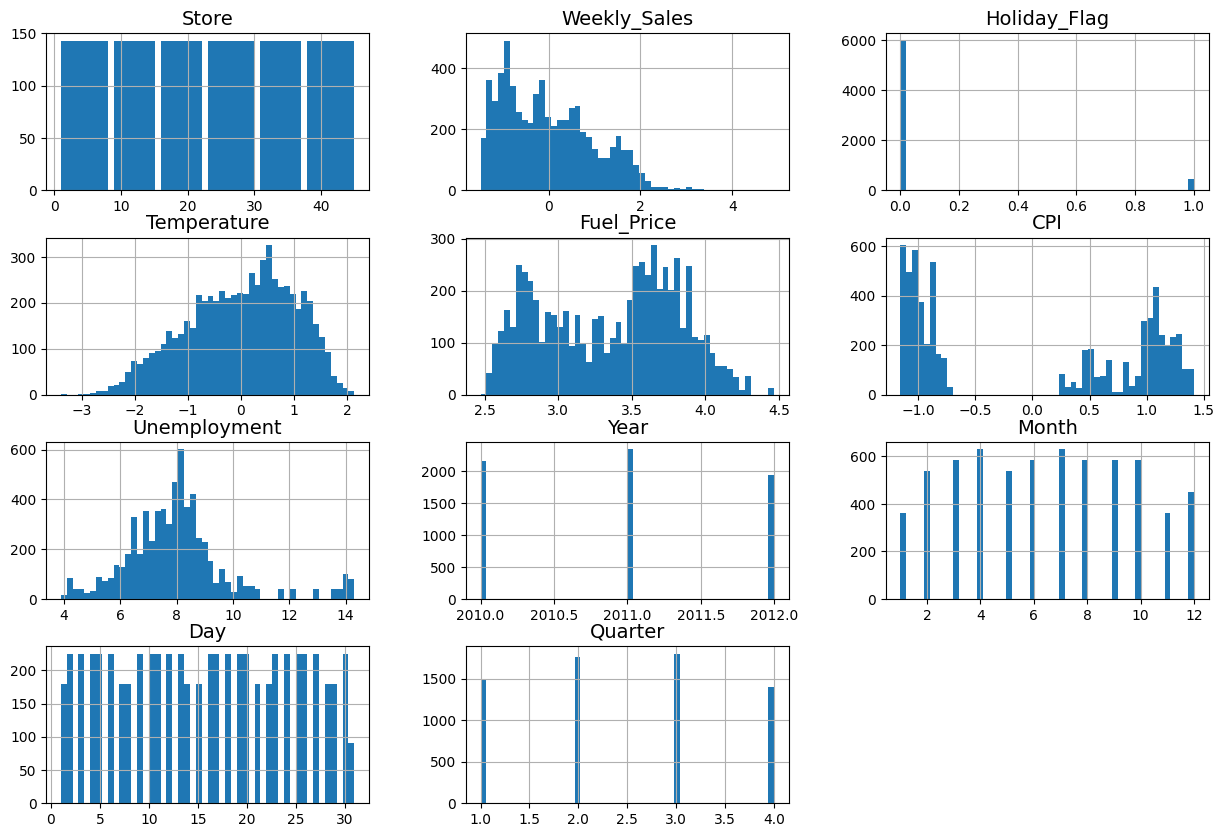

In [ ]:
data.hist(bins=50, figsize=(15, 10))
plt.show()

Correlation matrix to check to see which my strongest features are

In [ ]:
corr_matrix = data.corr(numeric_only = True)
corr_matrix["Weekly_Sales"].sort_values(ascending=False)

NameError: name 'data' is not defined

Looks like Month, Quarter and the presence of a holiday flag are currently my strongest features.

Need to establish train and test sets before continuing

In [ ]:
X = data.drop("Weekly_Sales", axis =1)
Y = data["Weekly_Sales"]

In [ ]:
#X['Fuel_Price'] = X["Fuel_Price"].apply(np.log)
#X['CPI']= X['CPI'].apply(np.log)

Attempted to use log to simplify distribution, did not get positive results

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Holiday_Flag  6435 non-null   int64  
 2   Temperature   6435 non-null   float64
 3   Fuel_Price    6435 non-null   float64
 4   CPI           6435 non-null   float64
 5   Unemployment  6435 non-null   float64
 6   Year          6435 non-null   int32  
 7   Month         6435 non-null   int32  
 8   Day           6435 non-null   int32  
 9   Quarter       6435 non-null   int32  
dtypes: float64(4), int32(4), int64(2)
memory usage: 402.3 KB


In [ ]:
Y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6435 entries, 0 to 6434
Series name: Weekly_Sales
Non-Null Count  Dtype  
--------------  -----  
6435 non-null   float64
dtypes: float64(1)
memory usage: 50.4 KB


Testing suggested lack of features led to model underfitting, going to try to use polynomial features to address this

In [ ]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

X and Y look to have the desired data, now to use test_train_split to create my training and testing sets

In [ ]:
#Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=72)
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X_poly, Y, train_size= 0.8, test_size = 0.2, random_state=72)

Low number of features makes me think that dimensionality reduction is going in the wrong direction, but going to make an attempt anyway.

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(Train_X)

In [ ]:
pca.n_components_

3

95% of variance is in 3 features, not optimistic about the results from this

# Model Selection

Going to start with linear regression to establish a baseline

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ("standardize", MinMaxScaler()),
])

num_attribs = ["Store", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Day", "Quarter"]

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs)

])

#lin_reg3 = make_pipeline(preprocessing, LinearRegression())
lin_reg = LinearRegression()
lin_reg2 = LinearRegression()
lin_reg.fit(Train_X, Train_Y)
lin_reg2.fit(X_reduced, Train_Y)


LinearRegression()

In [ ]:
#lin_reg3 = make_pipeline(preprocessing, LinearRegression())


In [ ]:
prediction= lin_reg.predict(Train_X)
prediction2 = lin_reg2.predict(X_reduced)
#prediction3 = lin_reg3.predict(Train_X)


In [ ]:
prediction

array([-0.06371599, -0.37338787,  0.34152914, ..., -0.3330972 ,
       -1.15445015, -0.038411  ])

In [ ]:
prediction2

array([-0.16884842, -0.1852307 , -0.13938252, ..., -0.35676243,
       -0.34037278, -0.18825794])

In [ ]:
#prediction3

In [ ]:
lin_rmse = mean_squared_error(Train_Y, prediction,
                              squared=False)

lin_rmse

0.7077141739353338

In [ ]:
lin_rmse2 = mean_squared_error(Train_Y, prediction2,
                              squared=False)
lin_rmse2

0.937362884715894

In [ ]:
#lin_rmse3 = mean_squared_error(Train_Y, prediction3, squared = False)
#lin_rmse3

NameError: name 'prediction3' is not defined

In [ ]:
lin_reg.score(Train_X, Train_Y)

0.4990034676026647

In [ ]:
lin_reg2.score(X_reduced, Train_Y)

0.12111016906287708

In [ ]:
#lin_reg3.score(Train_X, Train_Y)



*   Mean error is high across all attempts
* initial version included pipeline testing
*   Using polynomial features requires redoing pipeline, early use of pipeline had no impact
* Dimensionality reduction as expected lowers the score



In [ ]:
#X = X.drop("Day", axis=1)
#X = X.drop("Temperature", axis=1)

In [ ]:
#X = X.drop("Store", axis=1)

Next up going to try a random forest regressor

In [ ]:
RF_reg = RandomForestRegressor(random_state = 72)
RF_reg.fit(Train_X, Train_Y)
RF_reg.score(Train_X, Train_Y)

0.9940275072091664

In [ ]:
RF_reg_rmse = mean_squared_error(Train_Y, RF_reg.fit(Train_X, Train_Y).predict(Train_X), squared=False)

In [ ]:
RF_reg_rmse

0.07727132347908397

Random forest is doing very well without any fine tuning, should definitely keep this for final ensemble

Now to check on how SVM looks

In [ ]:
svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, random_state=72))
svm_reg.fit(Train_X, Train_Y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.5, random_state=72))])

In [ ]:
svm_rmse = mean_squared_error(Train_Y, svm_reg.fit(Train_X, Train_Y).predict(Train_X), squared = False)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
svm_rmse

0.7531600551323318

In [ ]:
svm_reg.score(Train_X, Train_Y)

0.4325945671859527

Score comparable to linear regression, potentially worth including in ensemble

# Ensemble Selection

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

In [ ]:
reg1 = GradientBoostingRegressor(random_state=72)
reg2 = RandomForestRegressor(random_state=72)
reg3 = lin_reg
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(Train_X, Train_Y)

In [ ]:
print(ereg.fit(Train_X, Train_Y).predict(Train_X))

In [ ]:
ereg_rmse = mean_squared_error(Train_Y, ereg.fit(Train_X, Train_Y).predict(Train_X), squared=False)

In [ ]:
ereg_rmse

In [ ]:
ereg.score(Train_X, Train_Y)

0.9019488074655304

Ensemble returns worse results than Random Forest by itself

# Results

Despite my desire being to make an ensemble model for this project, a prebuilt random forest regressor gave the best results on training data, so I will be using it for my test data alongside the ensemble.

In [ ]:
final_predictionA = RF_reg.predict(Test_X)
final_rmse_A = mean_squared_error(Test_Y, final_predictionA, squared = False)
RF_reg.score(Test_X, Test_Y)

0.9642467045384183

In [ ]:
final_rmse_A

In [ ]:
final_predictionB = ereg.predict(Test_X)
final_rmse_B = mean_squared_error(Test_Y, final_predictionB, squared = False)
ereg.score(Test_X, Test_Y)

0.8797854238761486



*   Random forest is ~3% worse with test data than training data
*   ensemble ~2% worse with test data



# Conclusions



* Linear regression behaves poorly when low features present
*   Linear Regression requires hefty fine tuning, underestimated time needed
*   Random Forest performs very well for this task
*   At times a prebuilt solution works best for a task
*  Dimensionality reduction is not worth exploring in datasets with low feature count (shocking)


